------------
# Trabalho de Mineração de Dados
-------
#### Francisco Wesley Pedro Lima

------
## Descrição do Dataset e Propósito Geral

O referido trabalho consistem em analisar os dados disponibilizados pelo [Portal da Agência Nacional do Petóleo, Gás Natural e Biocombustíveis (ANP)](http://www.anp.gov.br/precos-e-defesa-da-concorrencia/precos/levantamento-de-precos/serie-historica-do-levantamento-de-precos-e-de-margens-de-comercializacao-de-combustiveis) que traz uma serie de informações com relação aos valores de diversos combustíveis. Esses dados foram coletados no período compreendido entre maio de 2004 e junho de 2019, com informações coletadas semanalmente.

O principal propósito é analizar os dados, plotar algumas informações, com relação a consultas relaizadas sobre o dataset e ao final, fazer uma pequena comparação entre algoritmos de regressão de séries temporais. Como os dados disponíveis possuem uma ordem de leitura e informações consistentes relacionados a preços de revenda, tentar criar e  ajustar modelos que tentem predizer valores futuros pode ser de grande utilidade para o comércio ou mesmo para tentar predizer valores e fazer estimativas futuras.

Tendo em mente essas informações, vamos tentar agora criar modelos de regressão para predizer possíveis valores de dados com base nos algoritmos ARIMA, SARIMA e FBPROPHET

----
Mas antes de qualquer coisa, precisamos ler os dados, remover atributos desnecessários e mostrar algumas informações referentes ao mesmo e só assim depois, aplicar alguns algoritmos para Times Series

### Leitura e Limpeza dos Dados

#### Importando bibliotecas iniciais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline
plt.rcParams['figure.figsize'] = (5,20)

#### Configurando cabeçalho e fazendo a leitura dos dados

In [2]:
cabecalho =['DATA_INICIAL', 'DATA_FINAL','REGIAO','ESTADO','PRODUTO','NUMERO_DE_POSTOS_PESQUISADOS',
            'UNIDADE_DE_MEDIDA','PRECO_MEDIO_REVENDA','DESVIO_PADRAO_REVENDA','PRECO_MINIMO_REVENDA',
            'PRECO_MAXIMO_REVENDA','MARGEM_MEDIA_REVENDA','COEF_DE_VARIACAO_REVENDA',
            'PRECO_MEDIO_DISTRIBUICAO','DESVIO_PADRAO_DISTRIBUICAO','PRECO_MINIMO_DISTRIBUICAO',
            'PRECO_MAXIMO_DISTRIBUICAO','COEF_DE_VARIACAO_DISTRIBUICAO','MES','ANO']

df = pd.read_csv('gas-prices-in-brazil/2004-2019.tsv', sep='\t', names=cabecalho, header=0)

#### Pré-processamento dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 20 columns):
DATA_INICIAL                     106823 non-null object
DATA_FINAL                       106823 non-null object
REGIAO                           106823 non-null object
ESTADO                           106823 non-null object
PRODUTO                          106823 non-null object
NUMERO_DE_POSTOS_PESQUISADOS     106823 non-null int64
UNIDADE_DE_MEDIDA                106823 non-null object
PRECO_MEDIO_REVENDA              106823 non-null float64
DESVIO_PADRAO_REVENDA            106823 non-null float64
PRECO_MINIMO_REVENDA             106823 non-null float64
PRECO_MAXIMO_REVENDA             106823 non-null float64
MARGEM_MEDIA_REVENDA             106823 non-null object
COEF_DE_VARIACAO_REVENDA         106823 non-null float64
PRECO_MEDIO_DISTRIBUICAO         106823 non-null object
DESVIO_PADRAO_DISTRIBUICAO       106823 non-null object
PRECO_MINIMO_DISTRIBUICAO        106823 non-n

-----------
De acordo com os resultados do df.info(), alguns dos nossos valores são "object". Para evitar qualquer problema futuro, vamos transformá-los em valores numéricos

In [4]:
for col in ['MARGEM_MEDIA_REVENDA', 'PRECO_MEDIO_DISTRIBUICAO', 'DESVIO_PADRAO_DISTRIBUICAO', 
            'PRECO_MINIMO_DISTRIBUICAO', 'PRECO_MAXIMO_DISTRIBUICAO', 'COEF_DE_VARIACAO_DISTRIBUICAO']:
    # errors='coerce' - then invalid parsing will be set as NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 20 columns):
DATA_INICIAL                     106823 non-null object
DATA_FINAL                       106823 non-null object
REGIAO                           106823 non-null object
ESTADO                           106823 non-null object
PRODUTO                          106823 non-null object
NUMERO_DE_POSTOS_PESQUISADOS     106823 non-null int64
UNIDADE_DE_MEDIDA                106823 non-null object
PRECO_MEDIO_REVENDA              106823 non-null float64
DESVIO_PADRAO_REVENDA            106823 non-null float64
PRECO_MINIMO_REVENDA             106823 non-null float64
PRECO_MAXIMO_REVENDA             106823 non-null float64
MARGEM_MEDIA_REVENDA             103392 non-null float64
COEF_DE_VARIACAO_REVENDA         106823 non-null float64
PRECO_MEDIO_DISTRIBUICAO         103423 non-null float64
DESVIO_PADRAO_DISTRIBUICAO       103423 non-null float64
PRECO_MINIMO_DISTRIBUICAO        103423 no

------
Renomeando unidades de medida

In [5]:
unidades = {'R$/l':'litro', 'R$/13Kg':'13kg', 'R$/m3':'m3'}
df['UNIDADE_DE_MEDIDA'] = df['UNIDADE_DE_MEDIDA'].map(unidades)

--------
Substituir espaços em branco com _underscore_

In [6]:
df.columns = df.columns.str.replace("''", "")
df.columns = df.columns.str.replace('DISTRIBUICAO', 'DIST')

---------
Convertendo colunas _datetime_ para objetos _datetime_ e renomeia

In [7]:
df['DATA_INICIAL'] = pd.to_datetime(df["DATA_INICIAL"])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 20 columns):
DATA_INICIAL                    106823 non-null datetime64[ns]
DATA_FINAL                      106823 non-null object
REGIAO                          106823 non-null object
ESTADO                          106823 non-null object
PRODUTO                         106823 non-null object
NUMERO_DE_POSTOS_PESQUISADOS    106823 non-null int64
UNIDADE_DE_MEDIDA               106823 non-null object
PRECO_MEDIO_REVENDA             106823 non-null float64
DESVIO_PADRAO_REVENDA           106823 non-null float64
PRECO_MINIMO_REVENDA            106823 non-null float64
PRECO_MAXIMO_REVENDA            106823 non-null float64
MARGEM_MEDIA_REVENDA            103392 non-null float64
COEF_DE_VARIACAO_REVENDA        106823 non-null float64
PRECO_MEDIO_DIST                103423 non-null float64
DESVIO_PADRAO_DIST              103423 non-null float64
PRECO_MINIMO_DIST               103423 non-null f

In [9]:
df.head()

,DATA_INICIAL,DATA_FINAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,DESVIO_PADRAO_REVENDA,PRECO_MINIMO_REVENDA,PRECO_MAXIMO_REVENDA,MARGEM_MEDIA_REVENDA,COEF_DE_VARIACAO_REVENDA,PRECO_MEDIO_DIST,DESVIO_PADRAO_DIST,PRECO_MINIMO_DIST,PRECO_MAXIMO_DIST,COEF_DE_VARIACAO_DIST,MES,ANO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,litro,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.110,0.4201,0.96660,0.133,5,2004
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,litro,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05000,0.115,5,2004
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,litro,1.389,0.097,1.18,1.760,0.419,0.070,0.970,0.095,0.5614,1.16100,0.098,5,2004
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,litro,1.262,0.070,1.09,1.509,0.432,0.055,0.830,0.119,0.5991,1.22242,0.143,5,2004
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,litro,1.181,0.078,1.05,1.400,0.240,0.066,0.941,0.077,0.7441,1.03170,0.082,5,2004


In [10]:
df.isnull().sum()

DATA_INICIAL                       0
DATA_FINAL                         0
REGIAO                             0
ESTADO                             0
PRODUTO                            0
NUMERO_DE_POSTOS_PESQUISADOS       0
UNIDADE_DE_MEDIDA                  0
PRECO_MEDIO_REVENDA                0
DESVIO_PADRAO_REVENDA              0
PRECO_MINIMO_REVENDA               0
PRECO_MAXIMO_REVENDA               0
MARGEM_MEDIA_REVENDA            3431
COEF_DE_VARIACAO_REVENDA           0
PRECO_MEDIO_DIST                3400
DESVIO_PADRAO_DIST              3400
PRECO_MINIMO_DIST               3400
PRECO_MAXIMO_DIST               3400
COEF_DE_VARIACAO_DIST           3400
MES                                0
ANO                                0
dtype: int64

In [11]:
df['MARGEM_MEDIA_REVENDA'].fillna(df['MARGEM_MEDIA_REVENDA'].median(), inplace=True)
df['PRECO_MEDIO_DIST'].fillna(df['PRECO_MEDIO_DIST'].median(), inplace=True)
df['DESVIO_PADRAO_DIST'].fillna(df['DESVIO_PADRAO_DIST'].median(), inplace=True)
df['PRECO_MINIMO_DIST'].fillna(df['PRECO_MAXIMO_DIST'].median(), inplace=True)
df['PRECO_MAXIMO_DIST'].fillna(df['PRECO_MAXIMO_DIST'].median(), inplace=True)
df['COEF_DE_VARIACAO_DIST'].fillna(df['COEF_DE_VARIACAO_DIST'].median(), inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 20 columns):
DATA_INICIAL                    106823 non-null datetime64[ns]
DATA_FINAL                      106823 non-null object
REGIAO                          106823 non-null object
ESTADO                          106823 non-null object
PRODUTO                         106823 non-null object
NUMERO_DE_POSTOS_PESQUISADOS    106823 non-null int64
UNIDADE_DE_MEDIDA               106823 non-null object
PRECO_MEDIO_REVENDA             106823 non-null float64
DESVIO_PADRAO_REVENDA           106823 non-null float64
PRECO_MINIMO_REVENDA            106823 non-null float64
PRECO_MAXIMO_REVENDA            106823 non-null float64
MARGEM_MEDIA_REVENDA            106823 non-null float64
COEF_DE_VARIACAO_REVENDA        106823 non-null float64
PRECO_MEDIO_DIST                106823 non-null float64
DESVIO_PADRAO_DIST              106823 non-null float64
PRECO_MINIMO_DIST               106823 non-null f

#### Mostrando os diferentes tipos de produtos e as regiões presentes no nosso dataset

In [13]:
produtos = df['PRODUTO'].unique()
produtos

array(['ETANOL HIDRATADO', 'GASOLINA COMUM', 'GLP', 'GNV', 'ÓLEO DIESEL',
       'ÓLEO DIESEL S10'], dtype=object)

In [14]:
regioes = df['REGIAO'].unique()
regioes

array(['CENTRO OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL'],
      dtype=object)

### Visualização de Informações

---------
Uma maneira prática de se visualizar os dados e como os seus valores cresceram de acordo com o passar dos anos, seria fazendo consultas ao dataframe, usando restrições para retornar apenas o que desejamos.

No exemplo abaixo, fazemos uma consulta para ver como se deu o aumento do preço do gás de cozinha (GLP - Gás Liquefeito de Petróleo) em todas as regiões.

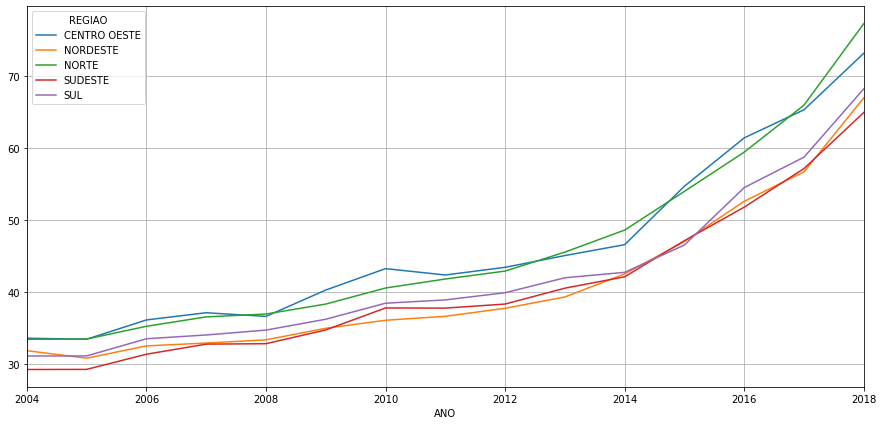

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
df.query('ANO != 2019 & PRODUTO in ["GLP"]').groupby(['ANO','REGIAO']).median()['PRECO_MEDIO_REVENDA'].unstack().plot(ax=ax)
plt.grid(True)

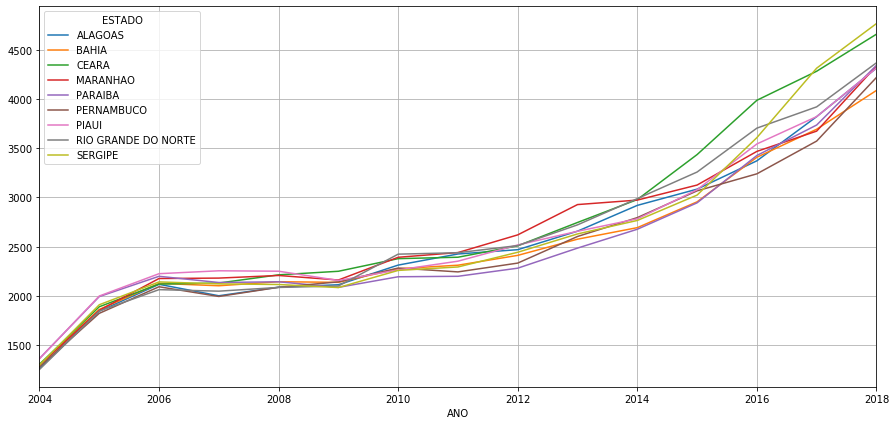

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
df.query('ANO != 2019 & REGIAO in ["NORDESTE"]').groupby(['ANO','ESTADO']).sum()['PRECO_MEDIO_REVENDA'].unstack().plot(ax=ax)
plt.grid(True)

---------
Para a análise que queremos fazer, alguns dados podem não ser nessários, para isso, podemos _dropar_ algumas colunas, de forma a simplificar um pouco mais nosso dataset.

In [17]:
dff = df.drop(['DATA_FINAL', 'DESVIO_PADRAO_REVENDA', 'PRECO_MINIMO_REVENDA', 'PRECO_MAXIMO_REVENDA', 
               'MARGEM_MEDIA_REVENDA', 'COEF_DE_VARIACAO_DIST', 'DESVIO_PADRAO_DIST', 'PRECO_MINIMO_DIST', 
               'PRECO_MAXIMO_DIST', 'COEF_DE_VARIACAO_REVENDA'], axis = 1)

In [18]:
dff.head()

,DATA_INICIAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,PRECO_MEDIO_DIST,MES,ANO
0,2004-05-09,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,litro,1.288,0.825,5,2004
1,2004-05-09,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,litro,1.162,0.763,5,2004
2,2004-05-09,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,litro,1.389,0.970,5,2004
3,2004-05-09,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,litro,1.262,0.830,5,2004
4,2004-05-09,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,litro,1.181,0.941,5,2004


In [19]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106823 entries, 0 to 106822
Data columns (total 10 columns):
DATA_INICIAL                    106823 non-null datetime64[ns]
REGIAO                          106823 non-null object
ESTADO                          106823 non-null object
PRODUTO                         106823 non-null object
NUMERO_DE_POSTOS_PESQUISADOS    106823 non-null int64
UNIDADE_DE_MEDIDA               106823 non-null object
PRECO_MEDIO_REVENDA             106823 non-null float64
PRECO_MEDIO_DIST                106823 non-null float64
MES                             106823 non-null int64
ANO                             106823 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 9.0+ MB


------
A seguir, será mostrado a quantidade de observações por cada região

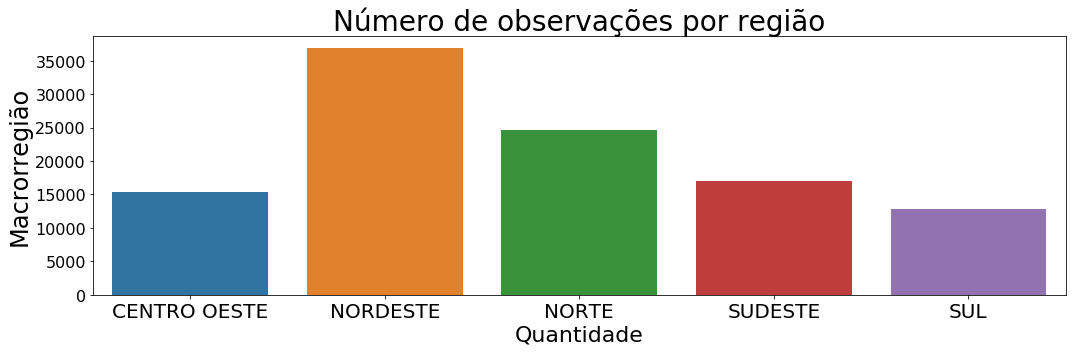

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x='REGIAO', data=dff)
plt.title('Número de observações por região', fontsize=28)
plt.xlabel('Quantidade', fontsize=22)
plt.ylabel('Macrorregião', fontsize=24)
plt.xticks(rotation=None, fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()

In [21]:
# Se verificarmos por estado, teremos então um melho ponto para analisar os dados
dff['ESTADO'].value_counts()

RIO DE JANEIRO         4263
CEARA                  4263
SAO PAULO              4263
RIO GRANDE DO SUL      4263
BAHIA                  4263
PARAIBA                4263
PERNAMBUCO             4262
RIO GRANDE DO NORTE    4262
SANTA CATARINA         4262
MINAS GERAIS           4261
ESPIRITO SANTO         4260
SERGIPE                4259
PARANA                 4251
ALAGOAS                4250
MATO GROSSO DO SUL     4246
MATO GROSSO            4037
AMAZONAS               3889
GOIAS                  3663
PIAUI                  3548
MARANHAO               3499
PARA                   3497
TOCANTINS              3483
DISTRITO FEDERAL       3483
ACRE                   3480
RONDONIA               3479
RORAIMA                3471
AMAPA                  3403
Name: ESTADO, dtype: int64

## Análise de Séries Temporais
-----
Como os dados apresentam uma série histórica com informações de preços de combustíveis coletados desde o ano de 2004, com informações de valor médio de revenda e datas de coletas que seguem uma ordem bem definida, então podemos ultilizar esse dataset para criar modelos preditivos , e com base em dados de um período anteriro específico, tentar predizer qual seria um próximo valor

Para analizar e predizer informações sobre um determinado produto, inicialmente vamos separar esse produto do conjunto de dados e tentar prever o seu valor apenas para um estado e um único produto em específico.

No nosso exemplo, iremos tomar como base o gás de cozinha (GLP) no Ceará. Inicialmente vamos separar os dados de todo o período e depois vamos separar esses dados em um conjunto para treino e outro conjunto para testes.

In [22]:
df_ceara_train = dff.loc[dff['PRODUTO'] == 'GLP'].loc[dff['ESTADO'] == 'CEARA'].loc[dff['ANO']!=2019]
glp_pp_ceara_test = dff.loc[dff['PRODUTO'] == 'GLP'].loc[dff['ESTADO'] == 'CEARA']

In [23]:
df_ceara_train.head()

,DATA_INICIAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,PRECO_MEDIO_DIST,MES,ANO
24138,2004-05-09,NORDESTE,CEARA,GLP,198,13kg,32.778,26.884,5,2004
24165,2004-05-16,NORDESTE,CEARA,GLP,194,13kg,32.743,27.662,5,2004
24192,2004-05-23,NORDESTE,CEARA,GLP,181,13kg,32.570,27.168,5,2004
24219,2004-05-30,NORDESTE,CEARA,GLP,212,13kg,32.610,27.353,5,2004
24246,2004-06-06,NORDESTE,CEARA,GLP,182,13kg,32.677,27.069,6,2004


In [24]:
df_ceara_train.tail()

,DATA_INICIAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,PRECO_MEDIO_DIST,MES,ANO
102434,2018-12-02,NORDESTE,CEARA,GLP,131,13kg,74.391,54.273,12,2018
102583,2018-12-09,NORDESTE,CEARA,GLP,131,13kg,72.945,52.776,12,2018
102732,2018-12-16,NORDESTE,CEARA,GLP,131,13kg,71.765,49.007,12,2018
102882,2018-12-23,NORDESTE,CEARA,GLP,131,13kg,71.945,48.797,12,2018
103033,2018-12-30,NORDESTE,CEARA,GLP,131,13kg,71.527,47.966,12,2018


In [25]:
df_ceara_test = dff.loc[dff['PRODUTO'] == 'GLP'].loc[dff['ESTADO'] == 'CEARA'].loc[dff['ANO']==2019]

In [26]:
df_ceara_test.head()

,DATA_INICIAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,PRECO_MEDIO_DIST,MES,ANO
103181,2019-01-06,NORDESTE,CEARA,GLP,131,13kg,71.762,49.390,1,2019
103331,2019-01-13,NORDESTE,CEARA,GLP,131,13kg,73.153,51.676,1,2019
103481,2019-01-20,NORDESTE,CEARA,GLP,131,13kg,72.878,51.880,1,2019
103631,2019-01-27,NORDESTE,CEARA,GLP,130,13kg,73.182,52.334,1,2019
103781,2019-02-03,NORDESTE,CEARA,GLP,130,13kg,72.103,52.030,2,2019


In [27]:
df_ceara_test.tail()

,DATA_INICIAL,REGIAO,ESTADO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,PRECO_MEDIO_DIST,MES,ANO
106188,2019-05-26,NORDESTE,CEARA,GLP,131,13kg,75.059,54.023,5,2019
106337,2019-06-02,NORDESTE,CEARA,GLP,131,13kg,73.777,53.454,6,2019
106487,2019-06-09,NORDESTE,CEARA,GLP,131,13kg,73.868,53.158,6,2019
106637,2019-06-16,NORDESTE,CEARA,GLP,131,13kg,73.437,52.668,6,2019
106786,2019-06-23,NORDESTE,CEARA,GLP,131,13kg,74.659,52.708,6,2019


In [28]:
glp_ceara_train = df_ceara_train[['DATA_INICIAL', 'PRECO_MEDIO_REVENDA']]

In [29]:
glp_ceara_train.head()

,DATA_INICIAL,PRECO_MEDIO_REVENDA
24138,2004-05-09,32.778
24165,2004-05-16,32.743
24192,2004-05-23,32.570
24219,2004-05-30,32.610
24246,2004-06-06,32.677


In [30]:
glp_ceara_test = df_ceara_test[['DATA_INICIAL', 'PRECO_MEDIO_REVENDA']]

In [31]:
glp_ceara_test.head()

,DATA_INICIAL,PRECO_MEDIO_REVENDA
103181,2019-01-06,71.762
103331,2019-01-13,73.153
103481,2019-01-20,72.878
103631,2019-01-27,73.182
103781,2019-02-03,72.103


### Algoritmo FB Prophet

#### Importando bibliotecas necessárias

In [32]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


Pré-processamento para ajuste de acordo com o algoritmo

In [33]:
glp_ceara_train.rename(columns={'DATA_INICIAL':'ds', 'PRECO_MEDIO_REVENDA':'y'}, inplace=True)

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [34]:
glp_ceara_test.rename(columns={'DATA_INICIAL':'ds', 'PRECO_MEDIO_REVENDA':'y'}, inplace=True)

In [35]:
glp_ceara_train.head()

,ds,y
24138,2004-05-09,32.778
24165,2004-05-16,32.743
24192,2004-05-23,32.570
24219,2004-05-30,32.610
24246,2004-06-06,32.677


In [36]:
glp_ceara_test.head()

,ds,y
103181,2019-01-06,71.762
103331,2019-01-13,73.153
103481,2019-01-20,72.878
103631,2019-01-27,73.182
103781,2019-02-03,72.103


In [37]:
glp_ceara_train.shape

(760, 2)

In [38]:
glp_ceara_test.shape

(25, 2)

#### Iniciando o trabalho com o Prophet

In [39]:
pp_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# 'Interval_width = 0.95', define o intervalo de incerteza 
# para produzir um intervalo de confiança em torno da previsão.

In [40]:
pp_model.fit(glp_ceara_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
glp_pp_forecast = pp_model.make_future_dataframe(periods=25, freq='W')

In [42]:
glp_pp_forecast = pp_model.predict(glp_pp_forecast)

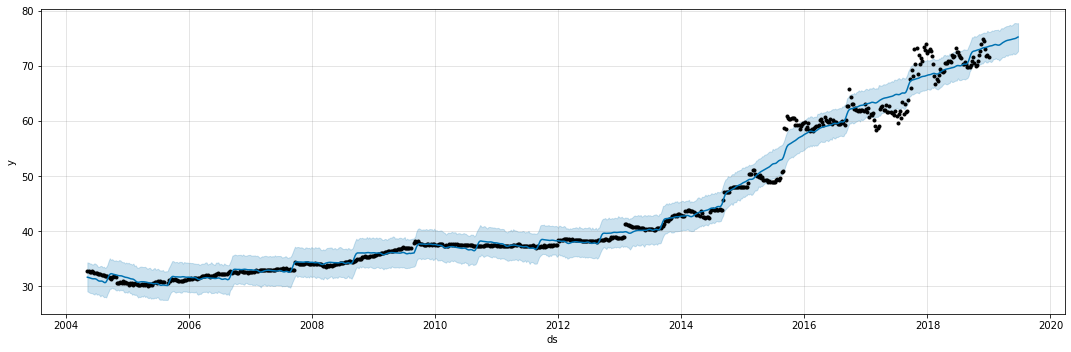

In [43]:
# Plotando o que foi predito
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = pp_model.plot(glp_pp_forecast, ax=ax)

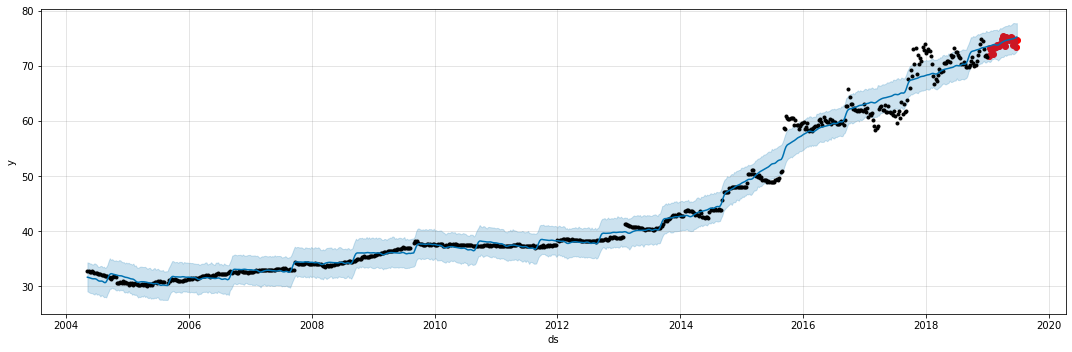

In [44]:
# Plota o predito junto com o real
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(glp_ceara_test['ds'], glp_ceara_test['y'], color='r')
fig = pp_model.plot(glp_pp_forecast, ax=ax)

In [45]:
glp_pp_forecast['yhat'].tail(25)

760    73.557616
761    73.588576
762    73.632899
763    73.719323
764    73.811594
765    73.841432
766    73.790407
767    73.722851
768    73.728179
769    73.837671
770    74.006664
771    74.171327
772    74.305749
773    74.419593
774    74.519055
775    74.593040
776    74.638272
777    74.676865
778    74.733178
779    74.801646
780    74.856835
781    74.897666
782    74.961190
783    75.074600
784    75.202679
Name: yhat, dtype: float64

In [46]:
print('MAE: ', metrics.mean_absolute_error(y_true=glp_pp_ceara_test['PRECO_MEDIO_REVENDA'],
                                           y_pred=glp_pp_forecast['yhat']))

MAE:  0.8911399741628621


In [47]:
print('MSE: ', metrics.mean_squared_error(y_true=glp_pp_ceara_test['PRECO_MEDIO_REVENDA'],
                                          y_pred=glp_pp_forecast['yhat']))

MSE:  1.808439367696726


In [48]:
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_true=glp_pp_ceara_test['PRECO_MEDIO_REVENDA'],
                                                   y_pred=glp_pp_forecast['yhat'])))

RMSE:  1.3447822752017242


Tentativa com outros algoritmos de Séries Temporais - ARIMA e SARIMA (Incompleto)

### Times Series Forecasting com ARIMA
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [49]:
from statsmodels.tsa.arima_model import ARIMA

In [50]:
glp_ceara_train.shape

(760, 2)

In [51]:
arima_train = glp_ceara_train.iloc[:,1]

In [52]:
ar_model = ARIMA(arima_train, order=(1,1,1))

/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [53]:
ar_model_fit = ar_model.fit(disp=False)

In [54]:
ar_model_predicted = ar_model_fit.predict(len(arima_train), len(arima_train))

/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [55]:
print(ar_model_predicted)

759    0.202223
dtype: float64


### Times Series Forecasting com SARIMA

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
sarima_train = glp_ceara_train.iloc[:,1]

In [58]:
sa_model = SARIMAX(sarima_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))

/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [59]:
sa_model_fit = sa_model.fit(disp=False)

In [60]:
sa_model_predicted = sa_model_fit.predict(len(sarima_train), len(sarima_train))

/home/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [61]:
print(sa_model_predicted)

760    71.030284
dtype: float64


Wesley Pedro